# resnet50, 13class, earlystop

In [7]:
import os
import re
import glob
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, mode = 'auto')

# Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# 이미지 로드 및 전처리
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, color_mode='rgb', target_size=target_size)
    image_array = img_to_array(image)
    image_array /= 255.0
    return image_array

# 파일 이름에서 session과 point 추출
def extract_session_and_point(filename):
    session_match = re.search(r'img_(\d+)', filename)
    point_match = re.search(r'\((\d+)\)', filename)
    session = int(session_match.group(1)) if session_match else None
    point = int(point_match.group(1)) if point_match else None
    return session, point

# ResNet-50
def create_resnet50_model(input_shape):
    input_layer = Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    filter_sizes = [64, 128, 256, 512]
    num_blocks = [3, 4, 6, 3]  # ResNet-50에서 각 블록별 반복 횟수
    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            x = bottleneck_block(x, filters, downsample=(i == 0 and filters != 64))
    
    x = layers.GlobalAveragePooling2D()(x)
    return Model(inputs=input_layer, outputs=x)

# 병목 구조
def resnet_block(x, filters, downsample=False):
    shortcut = x
    strides = (2, 2) if downsample else (1, 1)

    x = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)

    x = layers.Conv2D(filters * 4, kernel_size=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    
    x = layers.add([x, shortcut])
    x = layers.Activation(mish)(x)
    return x

# MLP 모델 생성
def create_mlp_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Dense(128, activation=mish)(input_layer)
    x = layers.Dense(64, activation=mish)(x)
    x = layers.Dense(3, activation=mish)(x)
    x = layers.Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

valid_labels = [1, 5, 9, 12, 16, 19, 23, 27, 30, 34, 37, 41, 45]

def prepare_data(folder_path, csv_path, test_subject, valid_labels):
    subject_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    train_subjects = [s for s in subject_folders if s != test_subject]
    
    # 학습 데이터 로드
    train_images, train_csv_data = [], pd.DataFrame()
    for train_subject in train_subjects:
        train_folder = os.path.join(folder_path, train_subject)
        train_csv = os.path.join(csv_path, f"{train_subject}.csv")
        train_images.extend(glob.glob(os.path.join(train_folder, '*.jpg')))
        if os.path.exists(train_csv):
            train_csv_data = pd.concat([train_csv_data, pd.read_csv(train_csv)])
    train_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 테스트 데이터 로드
    test_folder = os.path.join(folder_path, test_subject)
    test_csv = os.path.join(csv_path, f"{test_subject}.csv")
    test_images = glob.glob(os.path.join(test_folder, '*.jpg'))
    test_csv_data = pd.read_csv(test_csv) if os.path.exists(test_csv) else pd.DataFrame(columns=['Session', 'Point'])
    test_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 데이터 처리 함수
    def process_images(image_paths, csv_data, valid_labels):
        image_data = []
        for img in image_paths:
            session, point = extract_session_and_point(os.path.basename(img))
            if point in valid_labels:
                subject_name = os.path.basename(os.path.dirname(img))
                unique_filename = f"{subject_name}_{os.path.basename(img)}"
                image_data.append({
                    'Filename': os.path.abspath(img),
                    'UniqueFilename': unique_filename,
                    'Session': session,
                    'Point': point
                })
        df = pd.DataFrame(image_data)
        merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
        merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
        merged = merged[merged['Point'].isin(valid_labels)]
        return merged
    
    train_df = process_images(train_images, train_csv_data, valid_labels)
    test_df = process_images(test_images, test_csv_data, valid_labels)
    return train_df, test_df

from sklearn.model_selection import train_test_split

# hsh 폴더에서 train/test 분리 및 학습 진행
def train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject, test_size=0.2):
    print(f"Training and testing from folder: {subject}")
    
    # hsh 폴더 데이터 로드
    folder = os.path.join(folder_path, subject)
    csv_file = os.path.join(csv_path, f"{subject}.csv")
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))
    csv_data = pd.read_csv(csv_file) if os.path.exists(csv_file) else pd.DataFrame(columns=['Session', 'Point'])
    csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 이미지와 라벨 처리
    data = []
    for img in image_paths:
        session, point = extract_session_and_point(os.path.basename(img))
        if point in valid_labels:
            unique_filename = f"{subject}_{os.path.basename(img)}"
            data.append({
                'Filename': os.path.abspath(img),
                'UniqueFilename': unique_filename,
                'Session': session,
                'Point': point
            })
    df = pd.DataFrame(data)
    merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
    merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
    merged = merged[merged['Point'].isin(valid_labels)]
    
    # Train/Test Split
    train_df, test_df = train_test_split(merged, test_size=test_size, random_state=42, stratify=merged['Point'])
    
    train_images_array = np.array([load_and_preprocess_image(path) for path in train_df['Filename']])
    train_features = train_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    train_labels = train_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    train_labels = to_categorical(train_labels, num_classes=len(valid_labels))
    
    test_images_array = np.array([load_and_preprocess_image(path) for path in test_df['Filename']])
    test_features = test_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    test_labels = test_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    test_labels = to_categorical(test_labels, num_classes=len(valid_labels))
    
    # 모델 생성
    right_eye_model = create_resnet18_model((128, 128, 3))
    left_eye_model = create_resnet18_model((128, 128, 3))
    mlp_model = create_mlp_model(train_features.shape[1:])
    combined_input = layers.concatenate([right_eye_model.output, left_eye_model.output, mlp_model.output])
    x = layers.Dense(256, activation=mish)(combined_input)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(len(valid_labels), activation='softmax')(x)
    combined_model = Model(inputs=[right_eye_model.input, left_eye_model.input, mlp_model.input], outputs=output_layer)

    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = combined_model.fit(
        [train_images_array, train_images_array, train_features], train_labels,
        validation_data=([test_images_array, test_images_array, test_features], test_labels),
        epochs=50,
        batch_size=1,
        callbacks = [early_stopping],
        verbose=1
    )
    
    # 평가
    predictions = combined_model.predict([test_images_array, test_images_array, test_features])
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(test_labels, axis=1)

    loss, accuracy = combined_model.evaluate([test_images_array, test_images_array, test_features], test_labels)
    print(f"Testing accuracy for folder {subject}: {accuracy:.4f}")
    
    # 결과 저장
    results = []
    for idx, (image_path, feature, pred_class, actual_class) in enumerate(zip(
        test_df['Filename'], test_features, predicted_classes, actual_classes)):
        results.append({
            'Subject': subject,
            'Test Accuracy': accuracy,
            'Test Loss': loss,
            'Image File': image_path,
            'Feature': feature.tolist(),
            'Predicted Class': pred_class,
            'Actual Class': actual_class
        })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(csv_path, f"0103_results_{subject}.csv"), index=False, encoding='utf-8')
    print(f"Results for folder {subject} saved.")
    
    # 모델 저장
    model_save_path = os.path.join(csv_path, f"0103_model_{subject}.h5")
    combined_model.save(model_save_path)
    print(f"Model saved at: {model_save_path}")
    combined_model.summary()

# 데이터 경로
folder_path = r"C:\Users\admin\Desktop\sihoon\webcam\img"
csv_path = r"C:\Users\admin\Desktop\sihoon\webcam\results"
subject = 'hsh'

# 동일 폴더에서 train/test 분리 및 실행
train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject)

Training and testing from folder: hsh
Epoch 1/50


C:\Users\admin\.conda\envs\sihoon\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_467', 'keras_tensor_557', 'keras_tensor_647']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


520/520 ━━━━━━━━━━━━━━━━━━━━ 394s 429ms/step - accuracy: 0.0959 - loss: 4.7439 - val_accuracy: 0.0769 - val_loss: 7.6535
Epoch 2/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 121s 234ms/step - accuracy: 0.3064 - loss: 2.0610 - val_accuracy: 0.2692 - val_loss: 2.1890
Epoch 3/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 243s 428ms/step - accuracy: 0.4044 - loss: 1.5147 - val_accuracy: 0.5615 - val_loss: 1.2111
Epoch 4/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 180s 345ms/step - accuracy: 0.5843 - loss: 1.1684 - val_accuracy: 0.5692 - val_loss: 2.5182
Epoch 5/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 225s 432ms/step - accuracy: 0.5940 - loss: 1.1473 - val_accuracy: 0.5692 - val_loss: 1.6907
Epoch 6/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 226s 436ms/step - accuracy: 0.6839 - loss: 0.8289 - val_accuracy: 0.5615 - val_loss: 1.8322
Epoch 7/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 179s 344ms/step - accuracy: 0.7414 - loss: 0.7865 - val_accuracy: 0.5923 - val_loss: 1.6324
Epoch 8/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 228s 439ms/step - accuracy: 0.7727 - loss: 0.67

Testing accuracy for folder hsh: 0.6462
Results for folder hsh saved.
Model saved at: C:\Users\admin\Desktop\sihoon\webcam\results\0103_model_hsh.h5


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_10 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_138 (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ input_layer_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_167 (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_118       │ (None, 64, 64, 64)        │             256 │ conv2d_138[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_143       │ (None, 64, 64, 64)        │             256 │ conv2d_167[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_118 (Activation)   │ (None, 64, 64, 64)        │               0 │ batch_normalization_118[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_143 (Activation)   │ (None, 64, 64, 64)        │               0 │ batch_normalization_143[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 32, 32, 64)        │               0 │ activation_118[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 32, 32, 64)        │               0 │ activation_143[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_139 (Conv2D)           │ (None, 32, 32, 64)        │           4,160 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_168 (Conv2D)           │ (None, 32, 32, 64)        │           4,160 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_119       │ (None, 32, 32, 64)        │             256 │ conv2d_139[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_144       │ (None, 32, 32, 64)        │             256 │ conv2d_168[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 86,960,562 (331.73 MB)

 Trainable params: 28,971,408 (110.52 MB)

 Non-trainable params: 46,336 (181.00 KB)

 Optimizer params: 57,942,818 (221.03 MB)

In [ ]:
import os
import re
import glob
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100, mode = 'auto')

# Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# 이미지 로드 및 전처리
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, color_mode='rgb', target_size=target_size)
    image_array = img_to_array(image)
    image_array /= 255.0
    return image_array

# 파일 이름에서 session과 point 추출
def extract_session_and_point(filename):
    session_match = re.search(r'img_(\d+)', filename)
    point_match = re.search(r'\((\d+)\)', filename)
    session = int(session_match.group(1)) if session_match else None
    point = int(point_match.group(1)) if point_match else None
    return session, point

# ResNet18 모델 생성
def create_resnet18_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(5, 7), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.MaxPooling2D(pool_size=(2, 3), padding='same')(x)
    filter_sizes = [64, 128, 256, 512]
    num_blocks = [2, 2, 2, 2]
    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            x = resnet_block(x, filters, downsample=(i == 0 and filters != 64))
    x = layers.GlobalAveragePooling2D()(x)
    return Model(inputs=input_layer, outputs=x)

# ResNet 블록 생성
def resnet_block(x, filters, downsample=False):
    shortcut = x
    strides = (2, 2) if downsample else (1, 1)
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation(mish)(x)
    return x

# MLP 모델 생성
def create_mlp_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Dense(128, activation=mish)(input_layer)
    x = layers.Dense(64, activation=mish)(x)
    x = layers.Dense(3, activation=mish)(x)
    x = layers.Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

valid_labels = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]

def prepare_data(folder_path, csv_path, test_subject, valid_labels):
    subject_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    train_subjects = [s for s in subject_folders if s != test_subject]
    
    # 학습 데이터 로드
    train_images, train_csv_data = [], pd.DataFrame()
    for train_subject in train_subjects:
        train_folder = os.path.join(folder_path, train_subject)
        train_csv = os.path.join(csv_path, f"{train_subject}.csv")
        train_images.extend(glob.glob(os.path.join(train_folder, '*.jpg')))
        if os.path.exists(train_csv):
            train_csv_data = pd.concat([train_csv_data, pd.read_csv(train_csv)])
    train_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 테스트 데이터 로드
    test_folder = os.path.join(folder_path, test_subject)
    test_csv = os.path.join(csv_path, f"{test_subject}.csv")
    test_images = glob.glob(os.path.join(test_folder, '*.jpg'))
    test_csv_data = pd.read_csv(test_csv) if os.path.exists(test_csv) else pd.DataFrame(columns=['Session', 'Point'])
    test_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 데이터 처리 함수
    def process_images(image_paths, csv_data, valid_labels):
        image_data = []
        for img in image_paths:
            session, point = extract_session_and_point(os.path.basename(img))
            if point in valid_labels:
                subject_name = os.path.basename(os.path.dirname(img))
                unique_filename = f"{subject_name}_{os.path.basename(img)}"
                image_data.append({
                    'Filename': os.path.abspath(img),
                    'UniqueFilename': unique_filename,
                    'Session': session,
                    'Point': point
                })
        df = pd.DataFrame(image_data)
        merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
        merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
        merged = merged[merged['Point'].isin(valid_labels)]
        return merged
    
    train_df = process_images(train_images, train_csv_data, valid_labels)
    test_df = process_images(test_images, test_csv_data, valid_labels)
    return train_df, test_df

from sklearn.model_selection import train_test_split

# hsh 폴더에서 train/test 분리 및 학습 진행
def train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject, test_size=0.2):
    print(f"Training and testing from folder: {subject}")
    
    # hsh 폴더 데이터 로드
    folder = os.path.join(folder_path, subject)
    csv_file = os.path.join(csv_path, f"{subject}.csv")
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))
    csv_data = pd.read_csv(csv_file) if os.path.exists(csv_file) else pd.DataFrame(columns=['Session', 'Point'])
    csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 이미지와 라벨 처리
    data = []
    for img in image_paths:
        session, point = extract_session_and_point(os.path.basename(img))
        if point in valid_labels:
            unique_filename = f"{subject}_{os.path.basename(img)}"
            data.append({
                'Filename': os.path.abspath(img),
                'UniqueFilename': unique_filename,
                'Session': session,
                'Point': point
            })
    df = pd.DataFrame(data)
    merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
    merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
    merged = merged[merged['Point'].isin(valid_labels)]
    
    # Train/Test Split
    train_df, test_df = train_test_split(merged, test_size=test_size, random_state=42, stratify=merged['Point'])
    
    train_images_array = np.array([load_and_preprocess_image(path) for path in train_df['Filename']])
    train_features = train_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    train_labels = train_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    train_labels = to_categorical(train_labels, num_classes=len(valid_labels))
    
    test_images_array = np.array([load_and_preprocess_image(path) for path in test_df['Filename']])
    test_features = test_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    test_labels = test_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    test_labels = to_categorical(test_labels, num_classes=len(valid_labels))
    
    # 모델 생성
    right_eye_model = create_resnet18_model((128, 128, 3))
    left_eye_model = create_resnet18_model((128, 128, 3))
    mlp_model = create_mlp_model(train_features.shape[1:])
    combined_input = layers.concatenate([right_eye_model.output, left_eye_model.output, mlp_model.output])
    x = layers.Dense(256, activation=mish)(combined_input)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(len(valid_labels), activation='softmax')(x)
    combined_model = Model(inputs=[right_eye_model.input, left_eye_model.input, mlp_model.input], outputs=output_layer)

    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = combined_model.fit(
        [train_images_array, train_images_array, train_features], train_labels,
        validation_data=([test_images_array, test_images_array, test_features], test_labels),
        epochs=1000,
        batch_size=1,
        callbacks = [early_stopping],
        verbose=1
    )
    
    # 평가
    predictions = combined_model.predict([test_images_array, test_images_array, test_features])
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(test_labels, axis=1)

    loss, accuracy = combined_model.evaluate([test_images_array, test_images_array, test_features], test_labels)
    print(f"Testing accuracy for folder {subject}: {accuracy:.4f}")
    
    # 결과 저장
    results = []
    for idx, (image_path, feature, pred_class, actual_class) in enumerate(zip(
        test_df['Filename'], test_features, predicted_classes, actual_classes)):
        results.append({
            'Subject': subject,
            'Test Accuracy': accuracy,
            'Test Loss': loss,
            'Image File': image_path,
            'Feature': feature.tolist(),
            'Predicted Class': pred_class,
            'Actual Class': actual_class
        })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(csv_path, f"0103_results_{subject}.csv"), index=False, encoding='utf-8')
    print(f"Results for folder {subject} saved.")
    
    # 모델 저장
    model_save_path = os.path.join(csv_path, f"0103_model_{subject}.h5")
    combined_model.save(model_save_path)
    print(f"Model saved at: {model_save_path}")
    combined_model.summary()

# 데이터 경로
folder_path = r"C:\Users\admin\Desktop\sihoon\webcam\img"
csv_path = r"C:\Users\admin\Desktop\sihoon\webcam\results"
subject = 'hsh'

# 동일 폴더에서 train/test 분리 및 실행
train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject)

## 한 사람의 데이터로 1000에폭, resnet18, 23class로 의도적 과적합

In [ ]:
import os
import re
import glob
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100, mode = 'auto')

# Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# 이미지 로드 및 전처리
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, color_mode='rgb', target_size=target_size)
    image_array = img_to_array(image)
    image_array /= 255.0
    return image_array

# 파일 이름에서 session과 point 추출
def extract_session_and_point(filename):
    session_match = re.search(r'img_(\d+)', filename)
    point_match = re.search(r'\((\d+)\)', filename)
    session = int(session_match.group(1)) if session_match else None
    point = int(point_match.group(1)) if point_match else None
    return session, point

# ResNet18 모델 생성
def create_resnet18_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    filter_sizes = [64, 128, 256, 512]
    num_blocks = [2, 2, 2, 2]
    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            x = resnet_block(x, filters, downsample=(i == 0 and filters != 64))
    x = layers.GlobalAveragePooling2D()(x)
    return Model(inputs=input_layer, outputs=x)

# ResNet 블록 생성
def resnet_block(x, filters, downsample=False):
    shortcut = x
    strides = (2, 2) if downsample else (1, 1)
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation(mish)(x)
    return x

# MLP 모델 생성
def create_mlp_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Dense(128, activation=mish)(input_layer)
    x = layers.Dense(64, activation=mish)(x)
    x = layers.Dense(3, activation=mish)(x)
    x = layers.Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

# 학습 및 검증 정확도와 손실 시각화
def plot_training_history(history):
    # 정확도 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 손실 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

valid_labels = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]

def prepare_data(folder_path, csv_path, test_subject, valid_labels):
    subject_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    train_subjects = [s for s in subject_folders if s != test_subject]
    
    # 학습 데이터 로드
    train_images, train_csv_data = [], pd.DataFrame()
    for train_subject in train_subjects:
        train_folder = os.path.join(folder_path, train_subject)
        train_csv = os.path.join(csv_path, f"{train_subject}.csv")
        train_images.extend(glob.glob(os.path.join(train_folder, '*.jpg')))
        if os.path.exists(train_csv):
            train_csv_data = pd.concat([train_csv_data, pd.read_csv(train_csv)])
    train_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 테스트 데이터 로드
    test_folder = os.path.join(folder_path, test_subject)
    test_csv = os.path.join(csv_path, f"{test_subject}.csv")
    test_images = glob.glob(os.path.join(test_folder, '*.jpg'))
    test_csv_data = pd.read_csv(test_csv) if os.path.exists(test_csv) else pd.DataFrame(columns=['Session', 'Point'])
    test_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 데이터 처리 함수
    def process_images(image_paths, csv_data, valid_labels):
        image_data = []
        for img in image_paths:
            session, point = extract_session_and_point(os.path.basename(img))
            if point in valid_labels:
                subject_name = os.path.basename(os.path.dirname(img))
                unique_filename = f"{subject_name}_{os.path.basename(img)}"
                image_data.append({
                    'Filename': os.path.abspath(img),
                    'UniqueFilename': unique_filename,
                    'Session': session,
                    'Point': point
                })
        df = pd.DataFrame(image_data)
        merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
        merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
        merged = merged[merged['Point'].isin(valid_labels)]
        return merged
    
    train_df = process_images(train_images, train_csv_data, valid_labels)
    test_df = process_images(test_images, test_csv_data, valid_labels)
    return train_df, test_df

# hsh 폴더에서 train/test 분리 및 학습 진행
def train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject, test_size=0.2):
    print(f"Training and testing from folder: {subject}")
    
    # hsh 폴더 데이터 로드
    folder = os.path.join(folder_path, subject)
    csv_file = os.path.join(csv_path, f"{subject}.csv")
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))
    csv_data = pd.read_csv(csv_file) if os.path.exists(csv_file) else pd.DataFrame(columns=['Session', 'Point'])
    csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 이미지와 라벨 처리
    data = []
    for img in image_paths:
        session, point = extract_session_and_point(os.path.basename(img))
        if point in valid_labels:
            unique_filename = f"{subject}_{os.path.basename(img)}"
            data.append({
                'Filename': os.path.abspath(img),
                'UniqueFilename': unique_filename,
                'Session': session,
                'Point': point
            })
    df = pd.DataFrame(data)
    merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
    merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
    merged = merged[merged['Point'].isin(valid_labels)]
    
    # Train/Test Split
    train_df, test_df = train_test_split(merged, test_size=test_size, random_state=42, stratify=merged['Point'])
    
    train_images_array = np.array([load_and_preprocess_image(path) for path in train_df['Filename']])
    train_features = train_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    train_labels = train_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    train_labels = to_categorical(train_labels, num_classes=len(valid_labels))
    
    test_images_array = np.array([load_and_preprocess_image(path) for path in test_df['Filename']])
    test_features = test_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    test_labels = test_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    test_labels = to_categorical(test_labels, num_classes=len(valid_labels))
    
    # 모델 생성
    right_eye_model = create_resnet18_model((128, 128, 3))
    left_eye_model = create_resnet18_model((128, 128, 3))
    mlp_model = create_mlp_model(train_features.shape[1:])
    combined_input = layers.concatenate([right_eye_model.output, left_eye_model.output, mlp_model.output])
    x = layers.Dense(256, activation=mish)(combined_input)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(len(valid_labels), activation='softmax')(x)
    combined_model = Model(inputs=[right_eye_model.input, left_eye_model.input, mlp_model.input], outputs=output_layer)

    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = combined_model.fit(
        [train_images_array, train_images_array, train_features], train_labels,
        validation_data=([test_images_array, test_images_array, test_features], test_labels),
        epochs=500,
        batch_size=1,
        verbose=1
    )
    
    # 평가
    predictions = combined_model.predict([test_images_array, test_images_array, test_features])
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(test_labels, axis=1)

    loss, accuracy = combined_model.evaluate([test_images_array, test_images_array, test_features], test_labels)
    print(f"Testing accuracy for folder {subject}: {accuracy:.4f}")
    
    # 결과 저장
    results = []
    for idx, (image_path, feature, pred_class, actual_class) in enumerate(zip(
        test_df['Filename'], test_features, predicted_classes, actual_classes)):
        results.append({
            'Subject': subject,
            'Test Accuracy': accuracy,
            'Test Loss': loss,
            'Image File': image_path,
            'Feature': feature.tolist(),
            'Predicted Class': pred_class,
            'Actual Class': actual_class
        })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(csv_path, f"0103_results_{subject}.csv"), index=False, encoding='utf-8')
    print(f"Results for folder {subject} saved.")
    
    # 모델 저장
    model_save_path = os.path.join(csv_path, f"0103_model_{subject}.h5")
    combined_model.save(model_save_path)
    print(f"Model saved at: {model_save_path}")
    combined_model.summary()
    # 시각화
    plot_training_history(history)

# 데이터 경로
folder_path = r"C:\Users\admin\Desktop\sihoon\webcam\img"
csv_path = r"C:\Users\admin\Desktop\sihoon\webcam\results"
subject = 'hsh'

# 동일 폴더에서 train/test 분리 및 실행
train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject)

Training and testing from folder: hsh
Epoch 1/500


C:\Users\admin\.conda\envs\sihoon\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_934', 'keras_tensor_999', 'keras_tensor_1064']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 186s 184ms/step - accuracy: 0.0594 - loss: 3.9237 - val_accuracy: 0.1304 - val_loss: 2.6248
Epoch 2/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 166s 180ms/step - accuracy: 0.1959 - loss: 2.5086 - val_accuracy: 0.2870 - val_loss: 1.8495
Epoch 3/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 164s 179ms/step - accuracy: 0.3933 - loss: 1.7803 - val_accuracy: 0.4739 - val_loss: 1.3697
Epoch 4/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 165s 179ms/step - accuracy: 0.5130 - loss: 1.3361 - val_accuracy: 0.6391 - val_loss: 1.0027
Epoch 5/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 165s 179ms/step - accuracy: 0.6308 - loss: 0.9747 - val_accuracy: 0.6000 - val_loss: 1.2190
Epoch 6/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 165s 180ms/step - accuracy: 0.7090 - loss: 0.8221 - val_accuracy: 0.6652 - val_loss: 1.5789
Epoch 7/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 161s 174ms/step - accuracy: 0.8480 - loss: 0.5053 - val_accuracy: 0.5739 - val_loss: 2.6625
Epoch 8/500
920/920 ━━━━━━━━━━━━━━━━━━━━ 161s 174ms/step - accuracy: 0.8385 - los

Training and testing from folder: hsh
Epoch 1/250


C:\Users\admin\.conda\envs\sihoon\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_139', 'keras_tensor_204', 'keras_tensor_269']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 207s 208ms/step - accuracy: 0.0610 - loss: 3.7091 - val_accuracy: 0.1391 - val_loss: 3.1683
Epoch 2/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 207ms/step - accuracy: 0.2938 - loss: 2.0518 - val_accuracy: 0.4304 - val_loss: 1.7481
Epoch 3/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.5713 - loss: 1.1985 - val_accuracy: 0.5043 - val_loss: 1.3522
Epoch 4/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.6797 - loss: 0.8610 - val_accuracy: 0.5565 - val_loss: 1.3599
Epoch 5/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.8597 - loss: 0.4478 - val_accuracy: 0.5087 - val_loss: 1.5344
Epoch 6/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.8507 - loss: 0.4209 - val_accuracy: 0.6739 - val_loss: 0.9528
Epoch 7/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.9000 - loss: 0.2581 - val_accuracy: 0.7217 - val_loss: 0.9730
Epoch 8/250
920/920 ━━━━━━━━━━━━━━━━━━━━ 191s 208ms/step - accuracy: 0.8796 - los

Testing accuracy for folder hsh: 0.8913
Results for folder hsh saved.
Model saved at: C:\Users\admin\Desktop\sihoon\webcam\results\0103_model_hsh.h5


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 128, 128, 64)      │           6,784 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_60 (Conv2D)            │ (None, 128, 128, 64)      │           6,784 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_34        │ (None, 128, 128, 64)      │             256 │ conv2d_40[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_51        │ (None, 128, 128, 64)      │             256 │ conv2d_60[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_34 (Activation)    │ (None, 128, 128, 64)      │               0 │ batch_normalization_34[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_51 (Activation)    │ (None, 128, 128, 64)      │               0 │ batch_normalization_51[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 64, 43, 64)        │               0 │ activation_34[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 64, 43, 64)        │               0 │ activation_51[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 64, 43, 64)        │          36,928 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_61 (Conv2D)            │ (None, 64, 43, 64)        │          36,928 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_35        │ (None, 64, 43, 64)        │             256 │ conv2d_41[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_52        │ (None, 64, 43, 64)        │             256 │ conv2d_61[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 67,915,728 (259.08 MB)

 Trainable params: 22,633,370 (86.34 MB)

 Non-trainable params: 15,616 (61.00 KB)

 Optimizer params: 45,266,742 (172.68 MB)

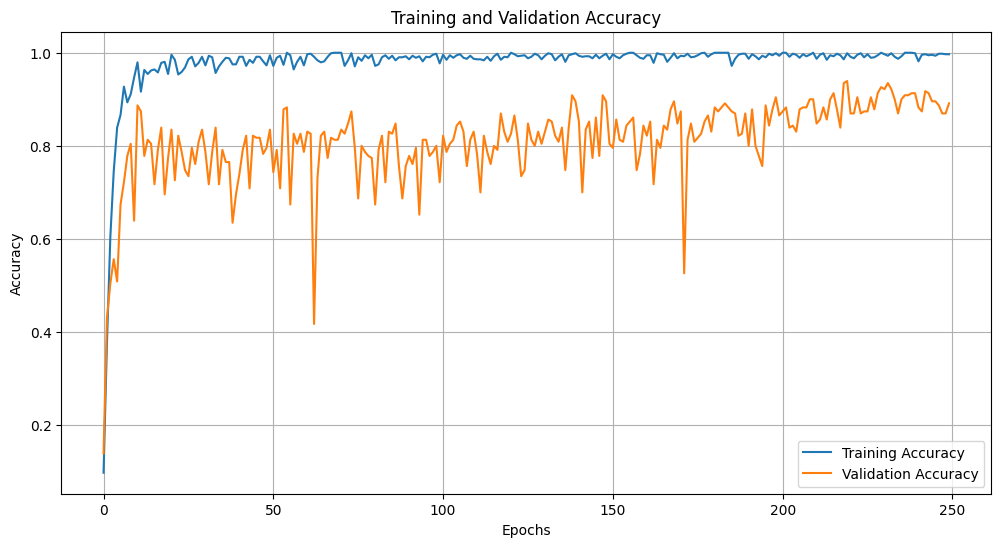

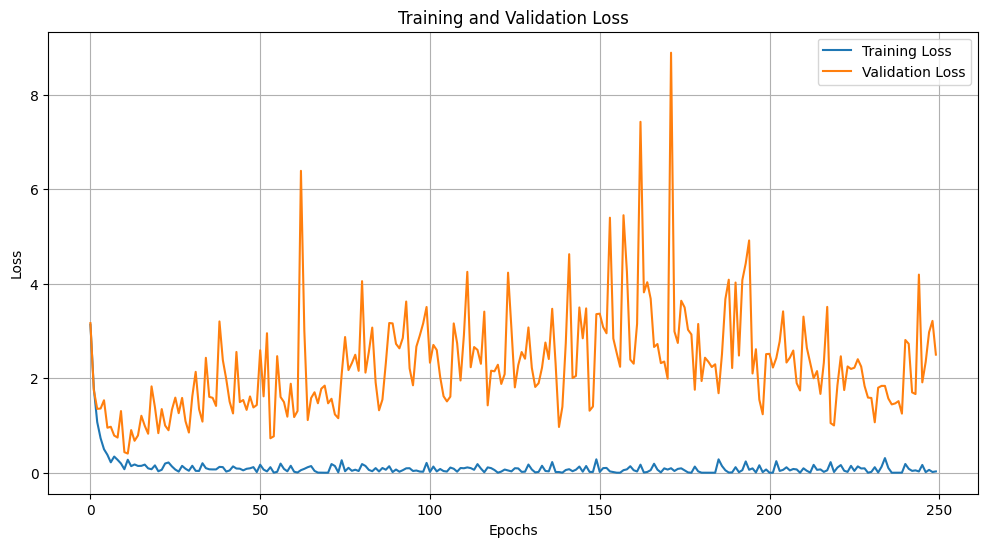

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100, mode = 'auto')

# Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# 이미지 로드 및 전처리
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, color_mode='rgb', target_size=target_size)
    image_array = img_to_array(image)
    image_array /= 255.0
    return image_array

# 파일 이름에서 session과 point 추출
def extract_session_and_point(filename):
    session_match = re.search(r'img_(\d+)', filename)
    point_match = re.search(r'\((\d+)\)', filename)
    session = int(session_match.group(1)) if session_match else None
    point = int(point_match.group(1)) if point_match else None
    return session, point

# ResNet18 모델 생성
def create_resnet18_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(5, 7), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.MaxPooling2D(pool_size=(2, 3), padding='same')(x)
    filter_sizes = [64, 128, 256, 512]
    num_blocks = [2, 2, 2, 2]
    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            x = resnet_block(x, filters, downsample=(i == 0 and filters != 64))
    x = layers.GlobalAveragePooling2D()(x)
    return Model(inputs=input_layer, outputs=x)

# ResNet 블록 생성
def resnet_block(x, filters, downsample=False):
    shortcut = x
    strides = (2, 2) if downsample else (1, 1)
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(mish)(x)
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation(mish)(x)
    return x

# MLP 모델 생성
def create_mlp_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = layers.Dense(128, activation=mish)(input_layer)
    x = layers.Dense(64, activation=mish)(x)
    x = layers.Dense(3, activation=mish)(x)
    x = layers.Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

# 학습 및 검증 정확도와 손실 시각화
def plot_training_history(history):
    # 정확도 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 손실 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

valid_labels = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]

def prepare_data(folder_path, csv_path, test_subject, valid_labels):
    subject_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    train_subjects = [s for s in subject_folders if s != test_subject]
    
    # 학습 데이터 로드
    train_images, train_csv_data = [], pd.DataFrame()
    for train_subject in train_subjects:
        train_folder = os.path.join(folder_path, train_subject)
        train_csv = os.path.join(csv_path, f"{train_subject}.csv")
        train_images.extend(glob.glob(os.path.join(train_folder, '*.jpg')))
        if os.path.exists(train_csv):
            train_csv_data = pd.concat([train_csv_data, pd.read_csv(train_csv)])
    train_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 테스트 데이터 로드
    test_folder = os.path.join(folder_path, test_subject)
    test_csv = os.path.join(csv_path, f"{test_subject}.csv")
    test_images = glob.glob(os.path.join(test_folder, '*.jpg'))
    test_csv_data = pd.read_csv(test_csv) if os.path.exists(test_csv) else pd.DataFrame(columns=['Session', 'Point'])
    test_csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 데이터 처리 함수
    def process_images(image_paths, csv_data, valid_labels):
        image_data = []
        for img in image_paths:
            session, point = extract_session_and_point(os.path.basename(img))
            if point in valid_labels:
                subject_name = os.path.basename(os.path.dirname(img))
                unique_filename = f"{subject_name}_{os.path.basename(img)}"
                image_data.append({
                    'Filename': os.path.abspath(img),
                    'UniqueFilename': unique_filename,
                    'Session': session,
                    'Point': point
                })
        df = pd.DataFrame(image_data)
        merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
        merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
        merged = merged[merged['Point'].isin(valid_labels)]
        return merged
    
    train_df = process_images(train_images, train_csv_data, valid_labels)
    test_df = process_images(test_images, test_csv_data, valid_labels)
    return train_df, test_df

# hsh 폴더에서 train/test 분리 및 학습 진행
def train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject, test_size=0.2):
    print(f"Training and testing from folder: {subject}")
    
    # hsh 폴더 데이터 로드
    folder = os.path.join(folder_path, subject)
    csv_file = os.path.join(csv_path, f"{subject}.csv")
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))
    csv_data = pd.read_csv(csv_file) if os.path.exists(csv_file) else pd.DataFrame(columns=['Session', 'Point'])
    csv_data.rename(columns={'session': 'Session', 'point': 'Point'}, inplace=True)
    
    # 이미지와 라벨 처리
    data = []
    for img in image_paths:
        session, point = extract_session_and_point(os.path.basename(img))
        if point in valid_labels:
            unique_filename = f"{subject}_{os.path.basename(img)}"
            data.append({
                'Filename': os.path.abspath(img),
                'UniqueFilename': unique_filename,
                'Session': session,
                'Point': point
            })
    df = pd.DataFrame(data)
    merged = pd.merge(df, csv_data, on=['Session', 'Point'], how='inner')
    merged = merged.drop_duplicates(subset=['UniqueFilename', 'Session', 'Point'])
    merged = merged[merged['Point'].isin(valid_labels)]
    
    # Train/Test Split
    train_df, test_df = train_test_split(merged, test_size=test_size, random_state=42, stratify=merged['Point'])
    
    train_images_array = np.array([load_and_preprocess_image(path) for path in train_df['Filename']])
    train_features = train_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    train_labels = train_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    train_labels = to_categorical(train_labels, num_classes=len(valid_labels))
    
    test_images_array = np.array([load_and_preprocess_image(path) for path in test_df['Filename']])
    test_features = test_df.drop(['Filename', 'UniqueFilename', 'Session', 'Point'], axis=1).values
    test_labels = test_df['Point'].map({label: idx for idx, label in enumerate(valid_labels)}).values
    test_labels = to_categorical(test_labels, num_classes=len(valid_labels))
    
    # 모델 생성
    right_eye_model = create_resnet18_model((128, 128, 3))
    left_eye_model = create_resnet18_model((128, 128, 3))
    mlp_model = create_mlp_model(train_features.shape[1:])
    combined_input = layers.concatenate([right_eye_model.output, left_eye_model.output, mlp_model.output])
    x = layers.Dense(256, activation=mish)(combined_input)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(len(valid_labels), activation='softmax')(x)
    combined_model = Model(inputs=[right_eye_model.input, left_eye_model.input, mlp_model.input], outputs=output_layer)

    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = combined_model.fit(
        [train_images_array, train_images_array, train_features], train_labels,
        validation_data=([test_images_array, test_images_array, test_features], test_labels),
        epochs=250,
        batch_size=1,
        verbose=1
    )
    
    # 평가
    predictions = combined_model.predict([test_images_array, test_images_array, test_features])
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(test_labels, axis=1)

    loss, accuracy = combined_model.evaluate([test_images_array, test_images_array, test_features], test_labels)
    print(f"Testing accuracy for folder {subject}: {accuracy:.4f}")
    
    # 결과 저장
    results = []
    for idx, (image_path, feature, pred_class, actual_class) in enumerate(zip(
        test_df['Filename'], test_features, predicted_classes, actual_classes)):
        results.append({
            'Subject': subject,
            'Test Accuracy': accuracy,
            'Test Loss': loss,
            'Image File': image_path,
            'Feature': feature.tolist(),
            'Predicted Class': pred_class,
            'Actual Class': actual_class
        })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(csv_path, f"0103_results_{subject}.csv"), index=False, encoding='utf-8')
    print(f"Results for folder {subject} saved.")
    
    # 모델 저장
    model_save_path = os.path.join(csv_path, f"0103_model_{subject}.h5")
    combined_model.save(model_save_path)
    print(f"Model saved at: {model_save_path}")
    combined_model.summary()
    # 시각화
    plot_training_history(history)

# 데이터 경로
folder_path = r"C:\Users\admin\Desktop\sihoon\webcam\img"
csv_path = r"C:\Users\admin\Desktop\sihoon\webcam\results"
subject = 'hsh'

# 동일 폴더에서 train/test 분리 및 실행
train_and_evaluate_from_single_folder(folder_path, csv_path, valid_labels, subject)



내 데이터 1000애ㅔ폭, 얼리스탑 ㄴ , - - --  



45클래스, 모든사람 데이터, 3폴드, 배치 4, 250에폭, 얼리스탑 걸고



테스트 데이터 확인 가능케




예정 
데이터 수집 방법 변경 -> 회귀로 2개 x y  값 예ㅒ측ㄱ 